# Mushroom Classification with Full EDA and XGBoost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef, roc_auc_score, roc_curve
from scipy.stats import zscore
import xgboost as xgb

In [2]:
df = pd.read_csv("data/raw/secondary_data.csv", delimiter=";")
df.columns = df.columns.str.replace("-", "_").str.strip()

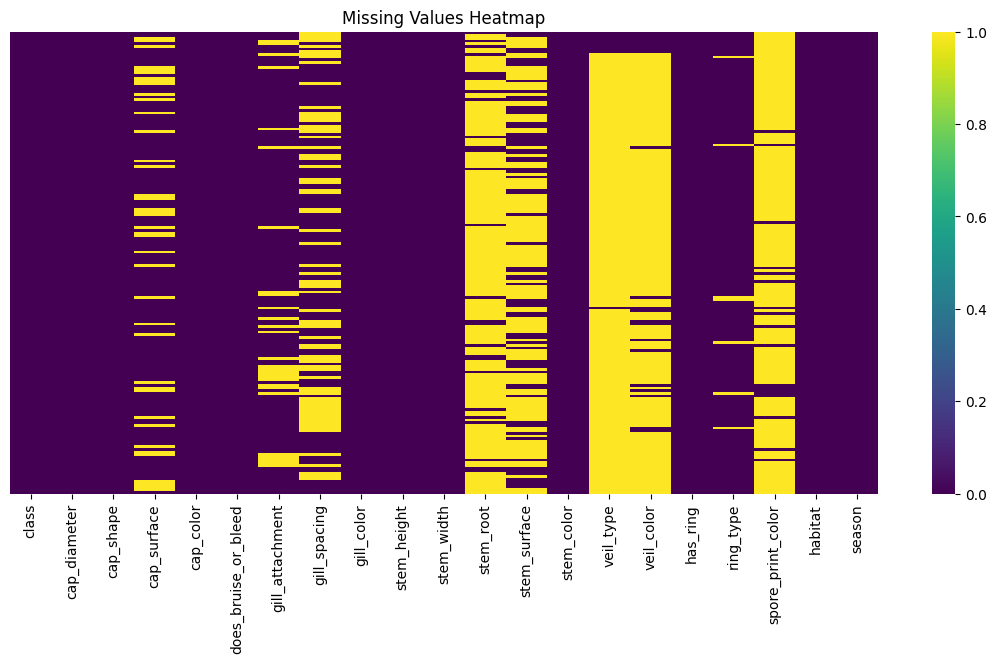

class                       0
cap_diameter                0
cap_shape                   0
cap_surface             14120
cap_color                   0
does_bruise_or_bleed        0
gill_attachment          9884
gill_spacing            25063
gill_color                  0
stem_height                 0
stem_width                  0
stem_root               51538
stem_surface            38124
stem_color                  0
veil_type               57892
veil_color              53656
has_ring                    0
ring_type                2471
spore_print_color       54715
habitat                     0
season                      0
dtype: int64

In [3]:
plt.figure(figsize=(14, 6))
sns.heatmap(df.isnull(), cbar=True, cmap='viridis', yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

df.isnull().sum()

/tmp/ipykernel_132887/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


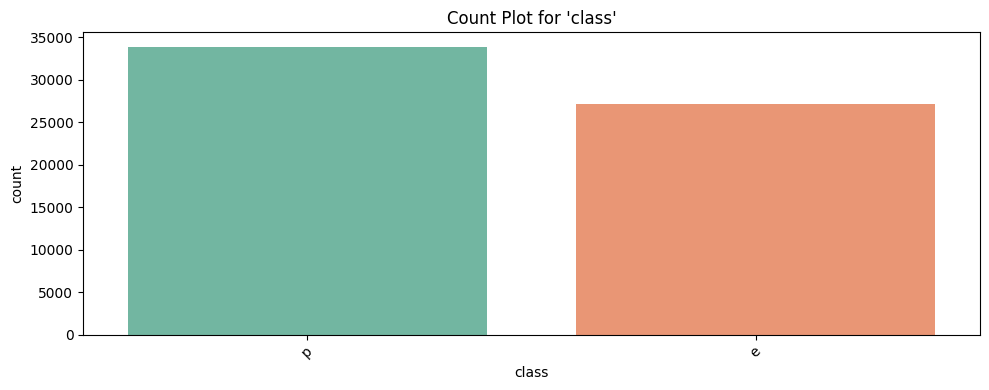

/tmp/ipykernel_132887/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


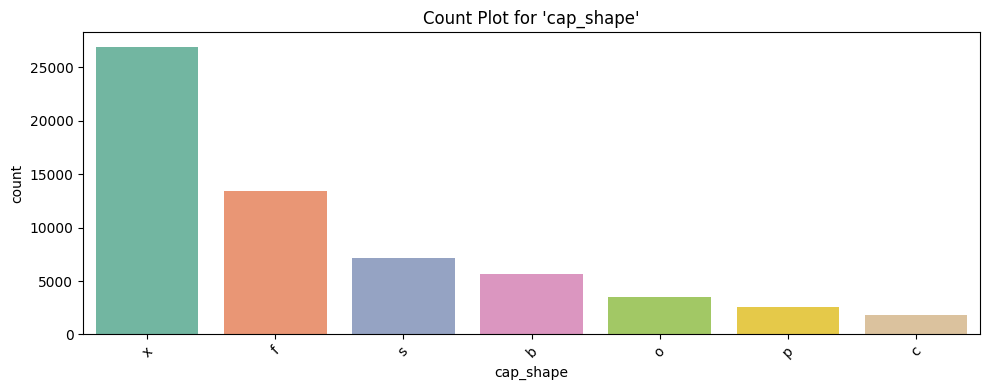

/tmp/ipykernel_132887/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


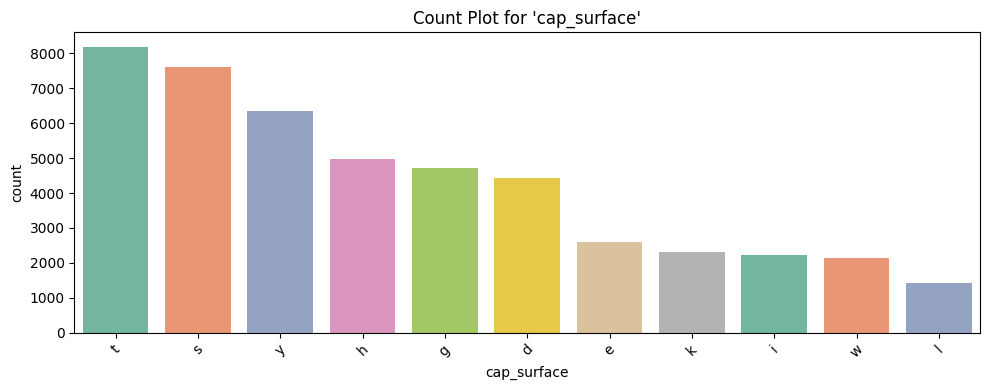

/tmp/ipykernel_132887/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


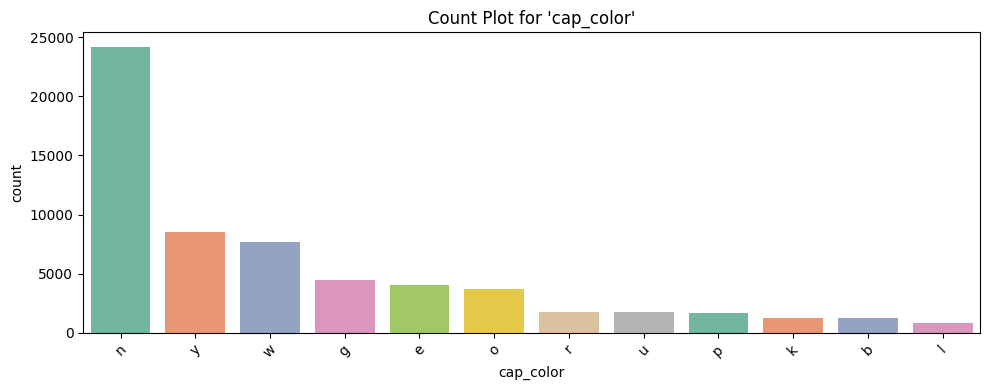

/tmp/ipykernel_132887/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


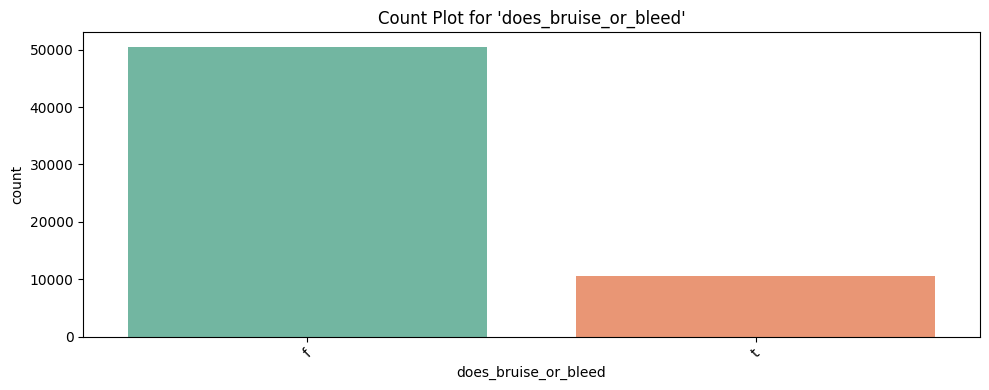

/tmp/ipykernel_132887/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


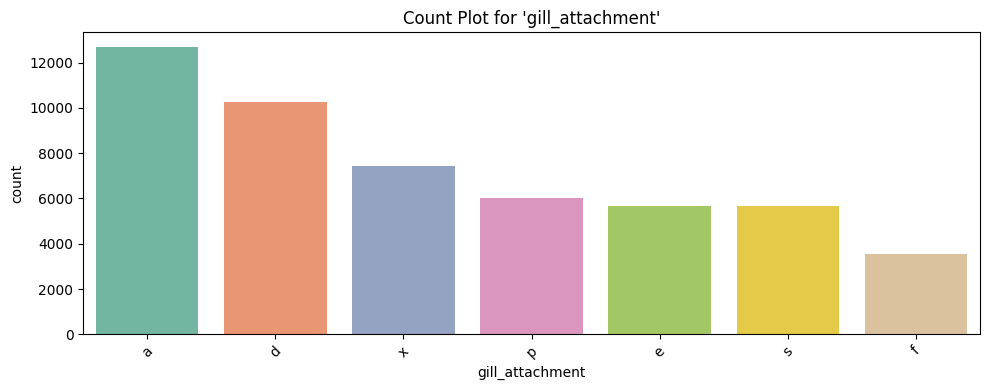

/tmp/ipykernel_132887/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


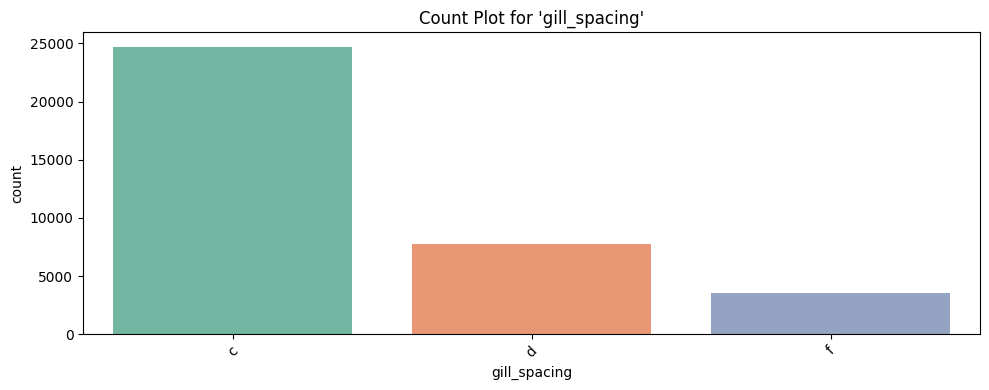

/tmp/ipykernel_132887/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


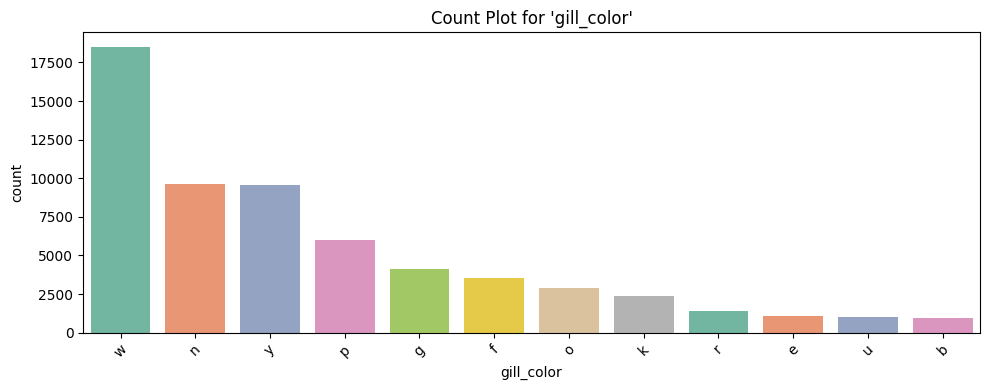

/tmp/ipykernel_132887/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


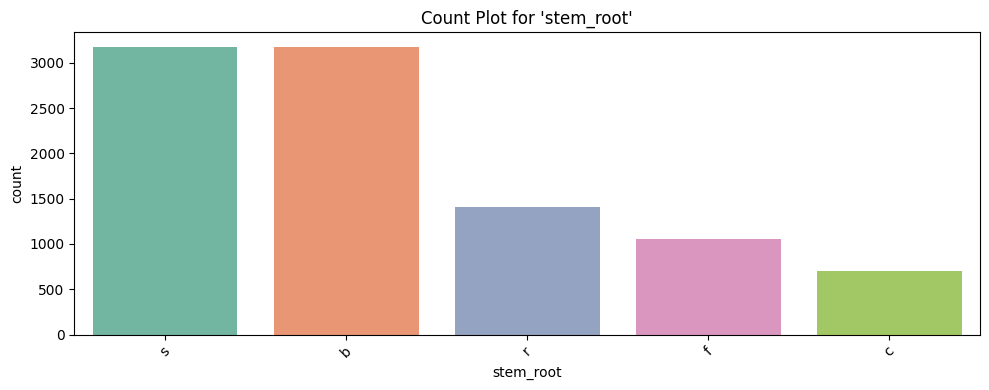

/tmp/ipykernel_132887/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


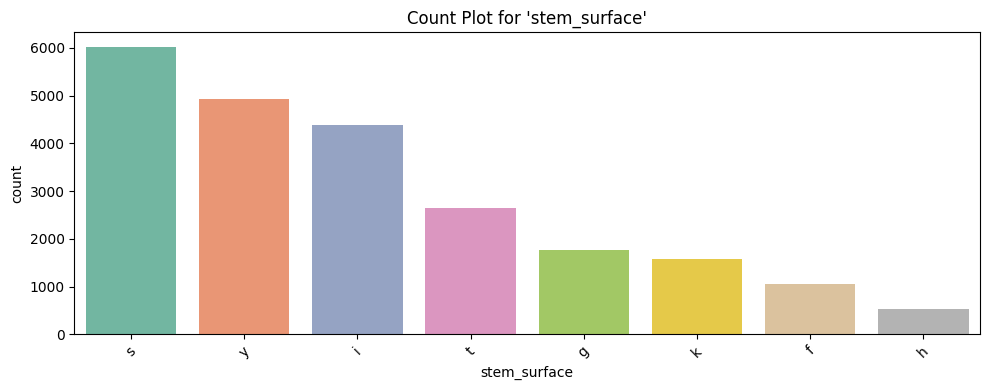

/tmp/ipykernel_132887/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


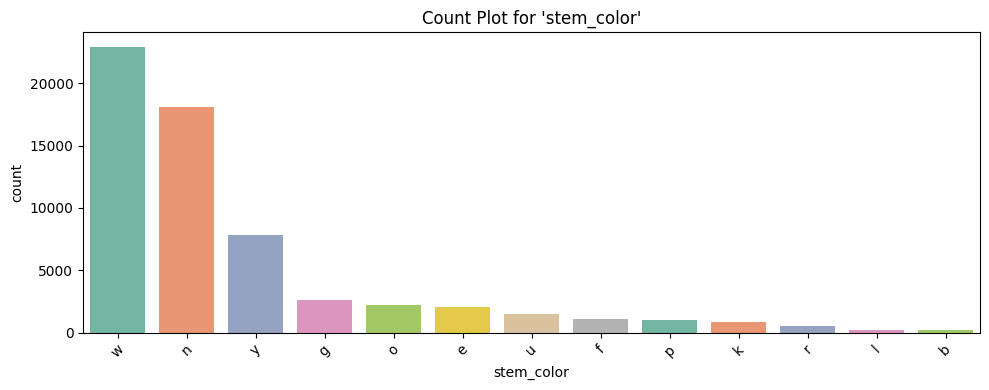

/tmp/ipykernel_132887/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


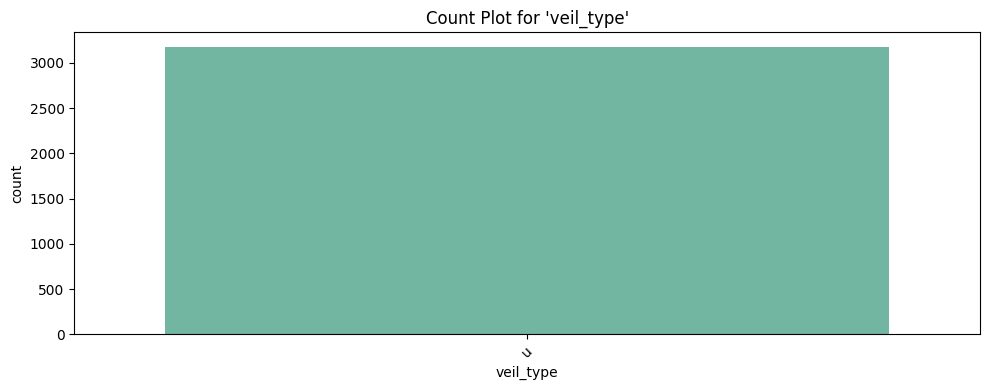

/tmp/ipykernel_132887/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


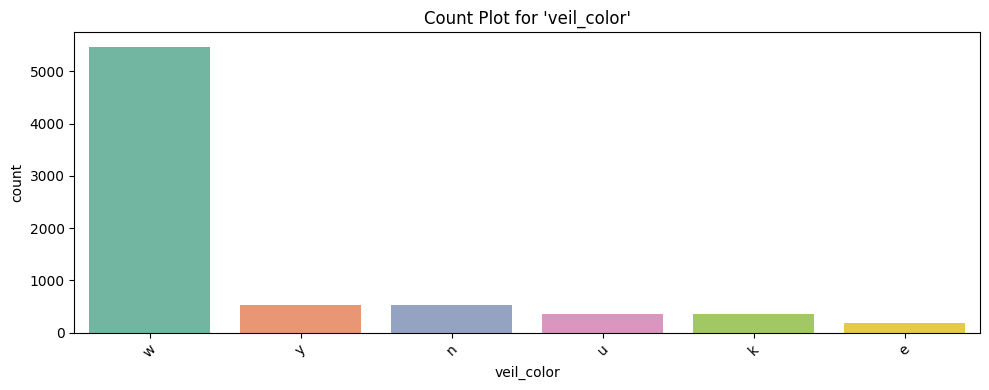

/tmp/ipykernel_132887/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


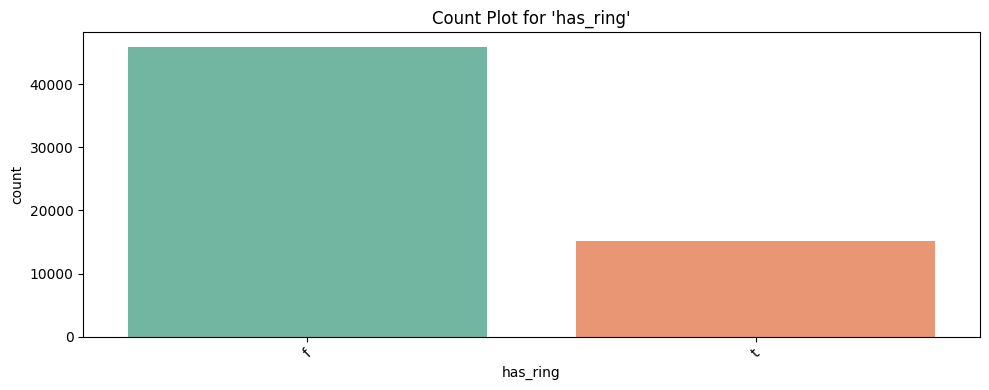

/tmp/ipykernel_132887/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


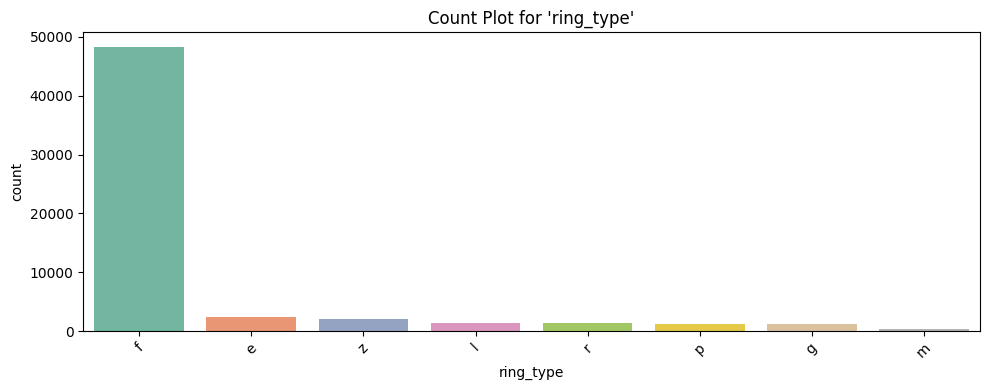

/tmp/ipykernel_132887/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


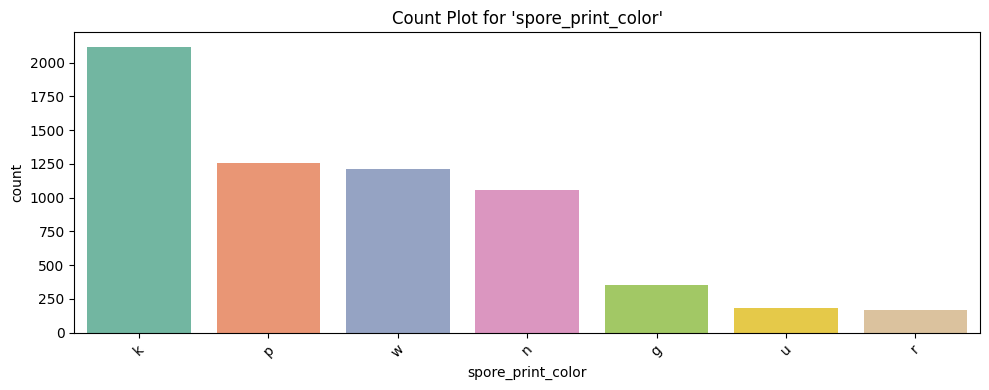

/tmp/ipykernel_132887/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


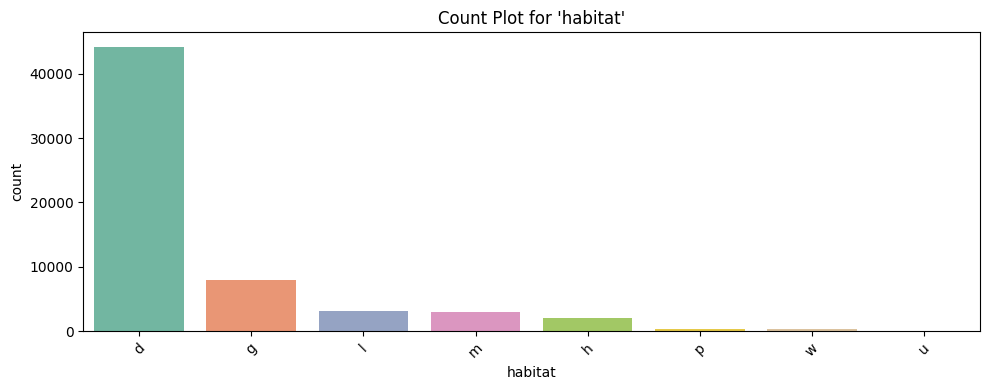

/tmp/ipykernel_132887/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


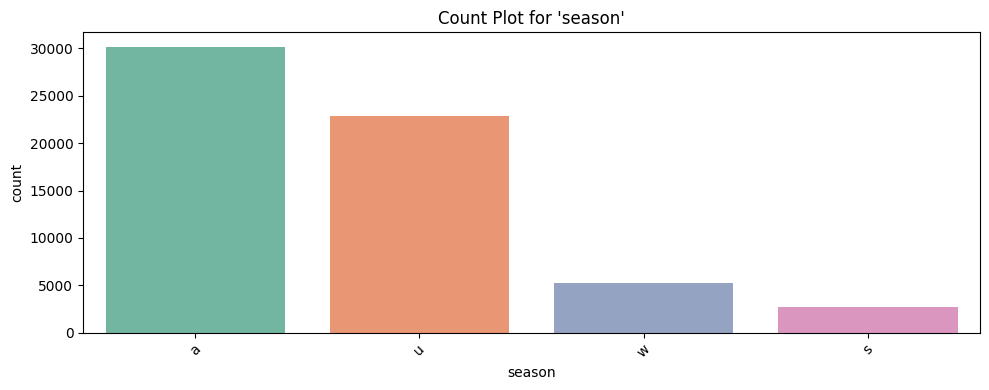

In [4]:
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')
    plt.xticks(rotation=45)
    plt.title(f"Count Plot for '{col}'")
    plt.tight_layout()
    plt.show()

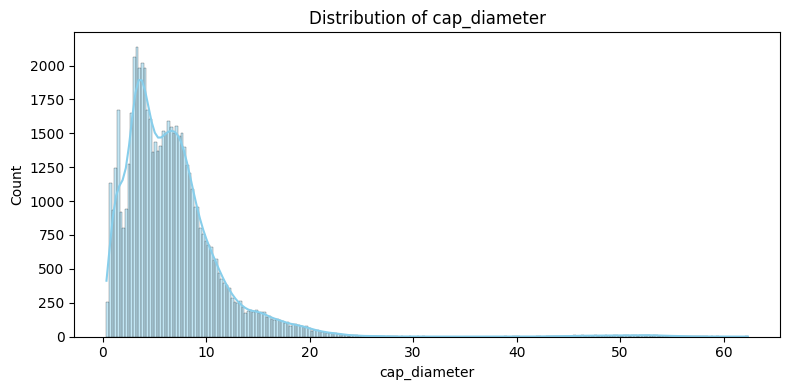

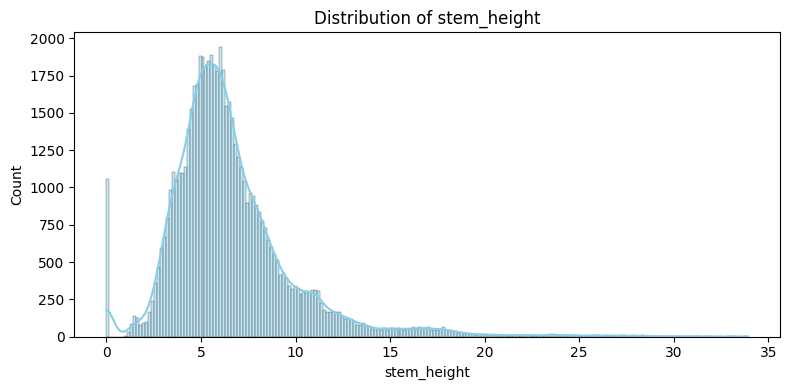

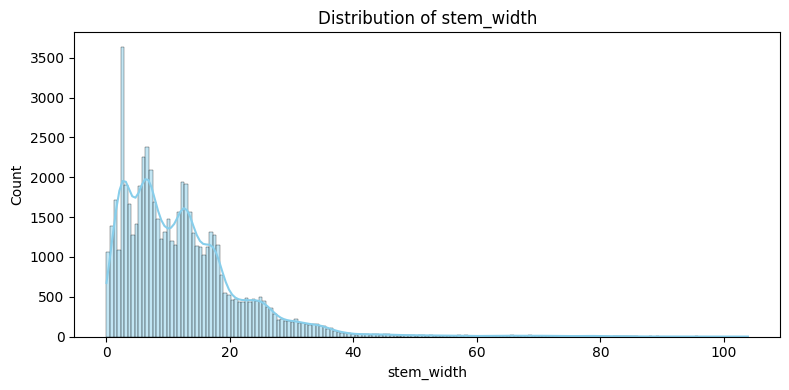

In [5]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('class_encoded', errors='ignore')
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

In [6]:
# Check which columns actually exist in the dataframe
columns_to_drop = ['gill_spacing', 'stem_surface', 'stem_root', 'spore_print_color', 'veil_type', 'veil_color']
existing_columns = [col for col in columns_to_drop if col in df.columns]

# Only drop columns that exist
if existing_columns:
    df.drop(columns=existing_columns, inplace=True)

label_encoder = LabelEncoder()

def encode_and_impute(column):
    encoded = label_encoder.fit_transform(df[column].astype(str))
    encoded = pd.Series(encoded)
    encoded[encoded == label_encoder.transform(['nan'])[0]] = np.nan
    
    # Get values to sample from non-NaN entries
    non_nan_values = encoded.dropna().values
    
    # Sample randomly from these values
    if encoded.isna().sum() > 0 and len(non_nan_values) > 0:
        sampled_values = np.random.choice(non_nan_values, size=encoded.isna().sum(), replace=True)
        # Create a copy and set the NaN values to the sampled values
        filled = encoded.copy()
        filled[filled.isna()] = sampled_values
    else:
        filled = encoded.copy()
        
    return label_encoder.inverse_transform(filled.astype(int))

# Check if these columns exist before trying to encode them
if 'cap_surface' in df.columns:
    df['cap_surface'] = encode_and_impute('cap_surface')
if 'gill_attachment' in df.columns:
    df['gill_attachment'] = encode_and_impute('gill_attachment')
if 'ring_type' in df.columns:
    df['ring_type'] = encode_and_impute('ring_type')

df['class_encoded'] = label_encoder.fit_transform(df['class'])
df['does_bruise_or_bleed_encoded'] = label_encoder.fit_transform(df['does_bruise_or_bleed'])
df['has_ring_encoded'] = label_encoder.fit_transform(df['has_ring'])

# Only process columns that exist
possible_columns = ['habitat', 'stem_color', 'gill_color', 'cap_color', 'cap_shape', 'cap_surface', 'ring_type']
for col in [col for col in possible_columns if col in df.columns]:
    rare_vals = df[col].value_counts()[df[col].value_counts() < 1000].index
    df[col] = df[col].replace(rare_vals, 'Other')

df.drop(columns=['class', 'does_bruise_or_bleed', 'has_ring'], inplace=True)

In [7]:
for col in ['cap_diameter', 'stem_height', 'stem_width']:
    df = df[(zscore(df[col]) < 2.5)]
df.reset_index(drop=True, inplace=True)

In [8]:
df = pd.get_dummies(df, drop_first=True)
X = df.drop(columns=['class_encoded'])
y = df['class_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)

dt = DecisionTreeClassifier(max_depth=12)
dt.fit(X_train, y_train)

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

/home/ankit/miniconda3/envs/mushroom_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ankit/miniconda3/envs/mushroom_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:19:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [10]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    print(f"\n--- {name} ---")
    print("Accuracy (Test):", accuracy_score(y_test, y_pred_test))
    print("Precision (Test):", precision_score(y_test, y_pred_test))
    print("Recall (Test):", recall_score(y_test, y_pred_test))
    print("F1 Score (Test):", f1_score(y_test, y_pred_test))
    print("MCC (Test):", matthews_corrcoef(y_test, y_pred_test))

evaluate_model("Logistic Regression", lr, X_train, y_train, X_test, y_test)
evaluate_model("Decision Tree", dt, X_train, y_train, X_test, y_test)
evaluate_model("XGBoost", xgb_model, X_train, y_train, X_test, y_test)


--- Logistic Regression ---
Accuracy (Test): 0.773882202453631
Precision (Test): 0.8075392670157068
Recall (Test): 0.7899211307999591
F1 Score (Test): 0.798633045099156
MCC (Test): 0.5410698495145284

--- Decision Tree ---
Accuracy (Test): 0.9460433746148031
Precision (Test): 0.9721064443731965
Recall (Test): 0.9316808358086653
F1 Score (Test): 0.9514644351464435
MCC (Test): 0.891803736605731

--- XGBoost ---
Accuracy (Test): 0.998720855863713
Precision (Test): 0.9989755148038111
Recall (Test): 0.9987708696097511
F1 Score (Test): 0.9988731817250563
MCC (Test): 0.9973941187175019


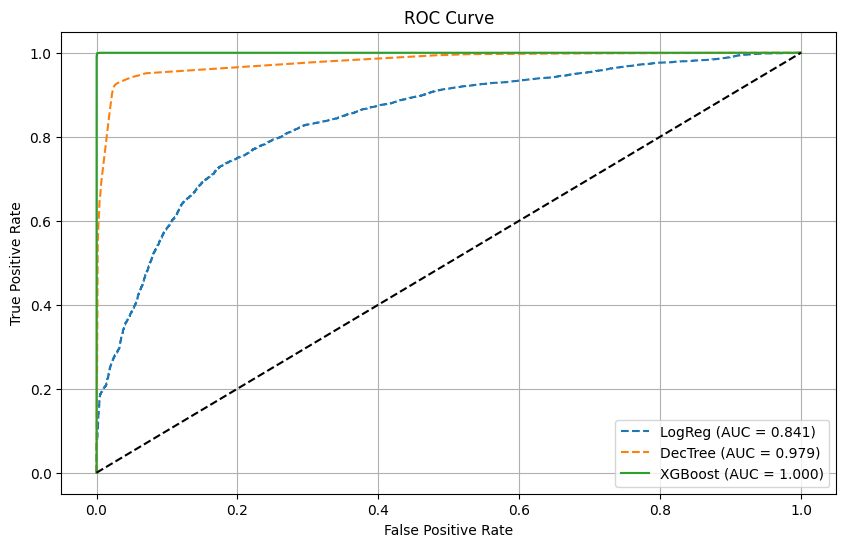

In [11]:
lr_probs = lr.predict_proba(X_test)[:, 1]
dt_probs = dt.predict_proba(X_test)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

plt.figure(figsize=(10, 6))
plt.plot(lr_fpr, lr_tpr, linestyle='--', label=f'LogReg (AUC = {roc_auc_score(y_test, lr_probs):.3f})')
plt.plot(dt_fpr, dt_tpr, linestyle='--', label=f'DecTree (AUC = {roc_auc_score(y_test, dt_probs):.3f})')
plt.plot(xgb_fpr, xgb_tpr, linestyle='-', label=f'XGBoost (AUC = {roc_auc_score(y_test, xgb_probs):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()


--- Logistic Regression ---
Accuracy (Test): 0.773882202453631
Precision (Test): 0.8075392670157068
Recall (Test): 0.7899211307999591
F1 Score (Test): 0.798633045099156
MCC (Test): 0.5410698495145284


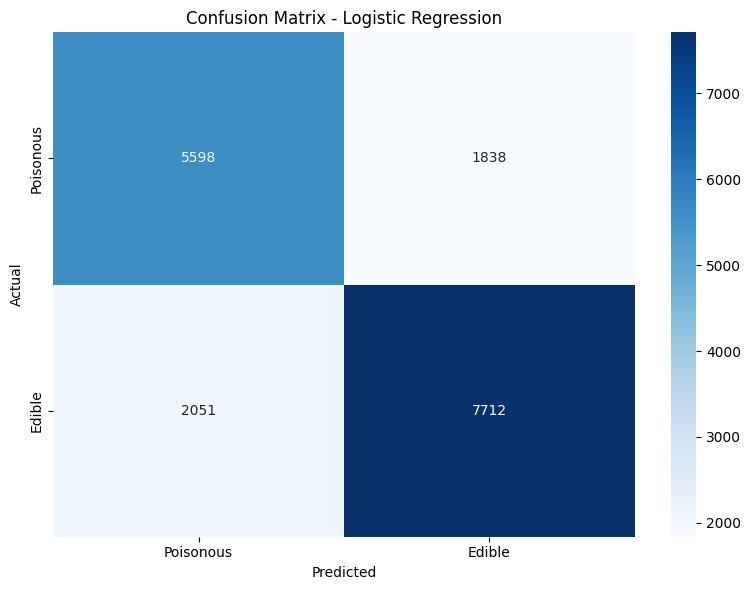


--- Decision Tree ---
Accuracy (Test): 0.9460433746148031
Precision (Test): 0.9721064443731965
Recall (Test): 0.9316808358086653
F1 Score (Test): 0.9514644351464435
MCC (Test): 0.891803736605731


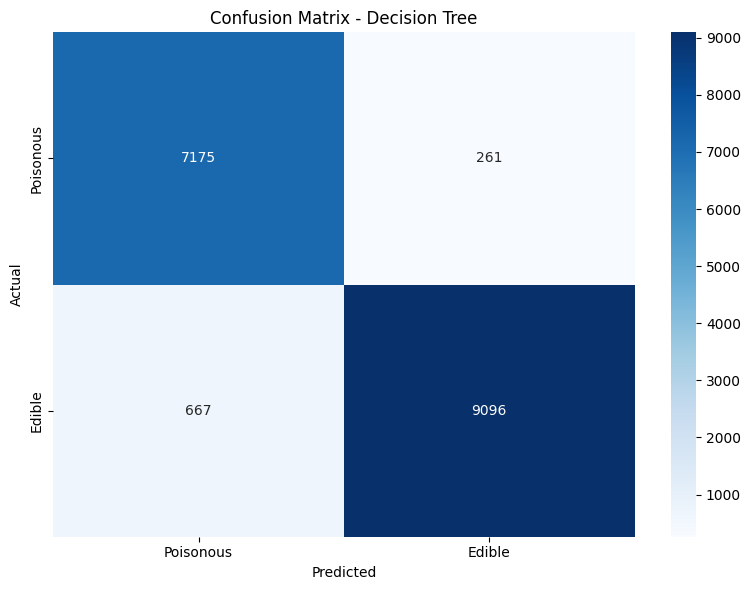


--- XGBoost ---
Accuracy (Test): 0.998720855863713
Precision (Test): 0.9989755148038111
Recall (Test): 0.9987708696097511
F1 Score (Test): 0.9988731817250563
MCC (Test): 0.9973941187175019


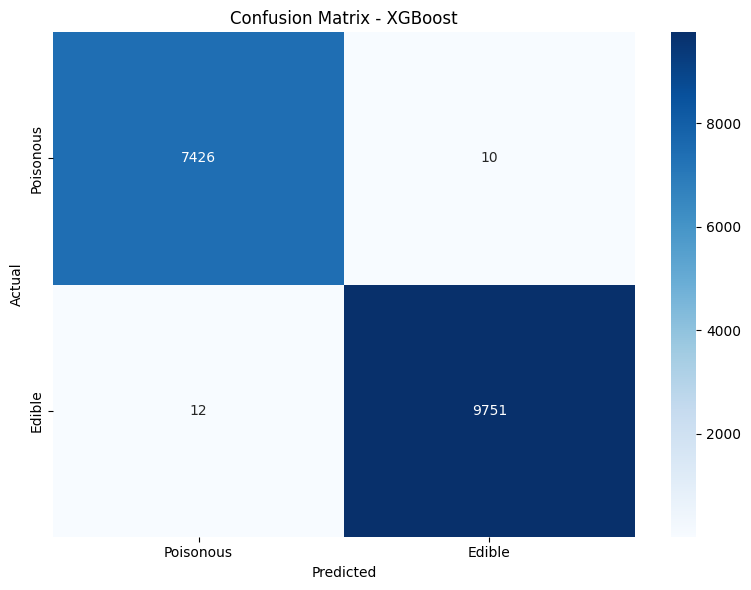

<Figure size 1400x800 with 0 Axes>

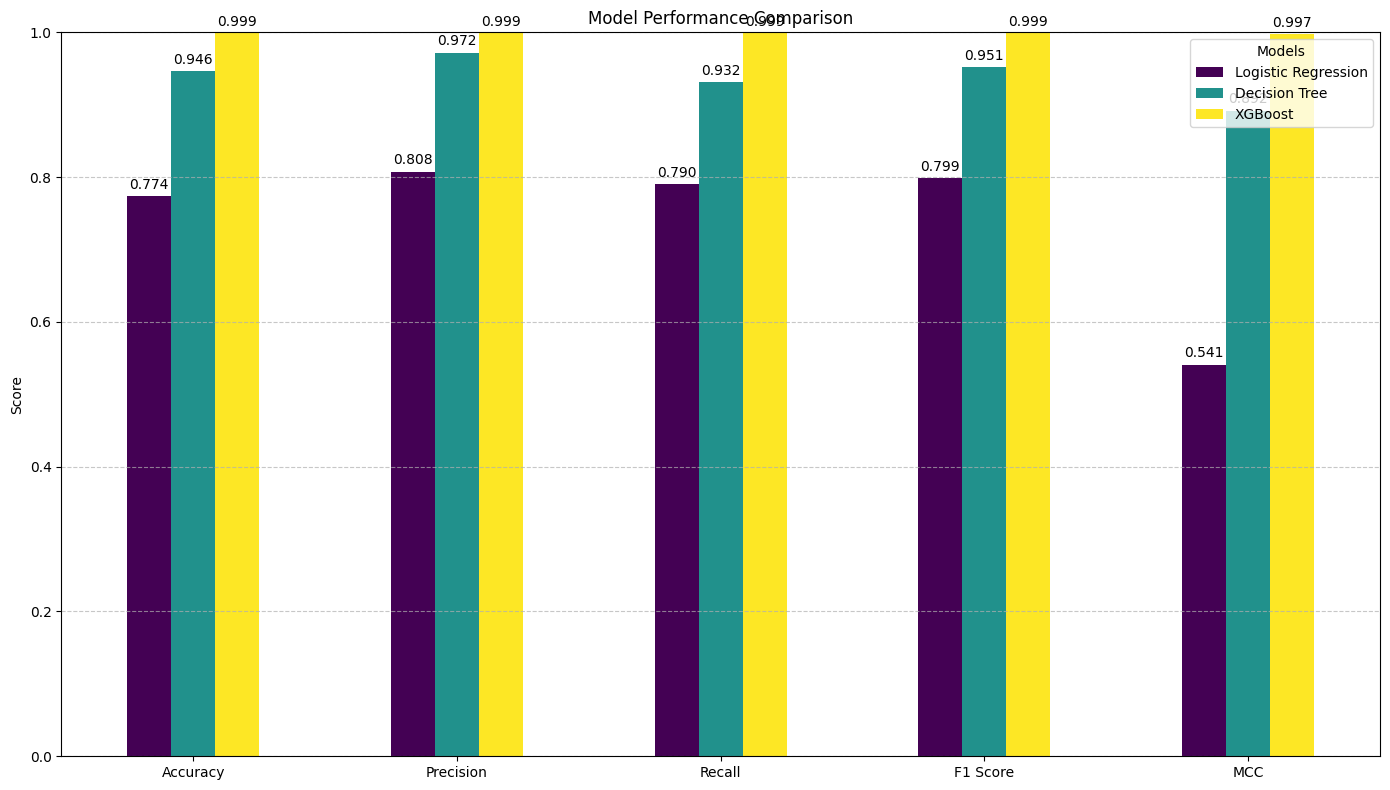

<Figure size 1200x800 with 0 Axes>

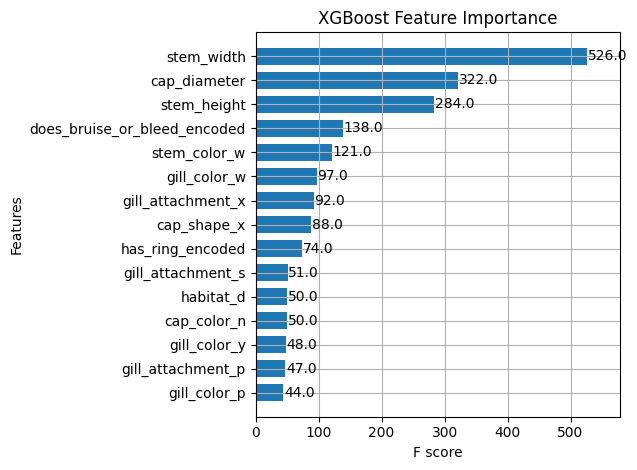

/home/ankit/miniconda3/envs/mushroom_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:21:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ankit/miniconda3/envs/mushroom_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:21:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ankit/miniconda3/envs/mushroom_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:21:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ankit/miniconda3/envs/mushroom_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:21:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ankit/miniconda3/envs/mushroom

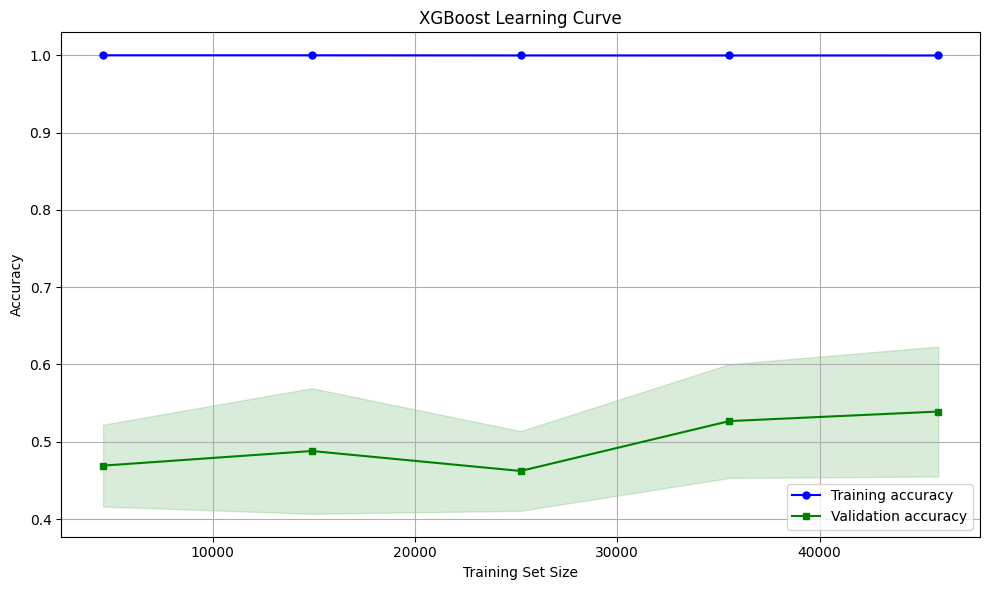

In [12]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    print(f"\n--- {name} ---")
    print("Accuracy (Test):", accuracy_score(y_test, y_pred_test))
    print("Precision (Test):", precision_score(y_test, y_pred_test))
    print("Recall (Test):", recall_score(y_test, y_pred_test))
    print("F1 Score (Test):", f1_score(y_test, y_pred_test))
    print("MCC (Test):", matthews_corrcoef(y_test, y_pred_test))
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Poisonous', 'Edible'],
                yticklabels=['Poisonous', 'Edible'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.tight_layout()
    plt.show()
    
    # Return metrics for comparison visualization
    return {
        'Accuracy': accuracy_score(y_test, y_pred_test),
        'Precision': precision_score(y_test, y_pred_test),
        'Recall': recall_score(y_test, y_pred_test),
        'F1 Score': f1_score(y_test, y_pred_test),
        'MCC': matthews_corrcoef(y_test, y_pred_test)
    }

# Collect metrics for all models
lr_metrics = evaluate_model("Logistic Regression", lr, X_train, y_train, X_test, y_test)
dt_metrics = evaluate_model("Decision Tree", dt, X_train, y_train, X_test, y_test)
xgb_metrics = evaluate_model("XGBoost", xgb_model, X_train, y_train, X_test, y_test)

# Create comparative bar chart for all metrics
metrics_df = pd.DataFrame({
    'Logistic Regression': lr_metrics,
    'Decision Tree': dt_metrics,
    'XGBoost': xgb_metrics
})

# Plot comparative metrics
plt.figure(figsize=(14, 8))
metrics_df.plot(kind='bar', figsize=(14, 8), colormap='viridis')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0, 1.0)  # Metrics are between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Models')
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.3f', padding=3)
plt.tight_layout()
plt.show()

# Feature importance for XGBoost
plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_model, max_num_features=15, height=0.7)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# Add learning curves for XGBoost
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    X, y, cv=5, scoring='accuracy', n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('XGBoost Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()